In [59]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu128
Device: cuda


In [60]:
# Read the dataset into a DataFrame with specified column names
df = pd.read_csv('pirate_pain_train.csv', header=0)

df_labels = pd.read_csv('pirate_pain_train_labels.csv', header=0)

# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")

# Display the first 10 rows of the DataFrame
df.head(10)

DataFrame shape: (105760, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.073167e-06,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.074800e-06,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5
7,0,7,2,2,2,2,two,two,two,1.038597,...,8.829074e-07,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.621055e-06,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5
9,0,9,0,2,2,2,two,two,two,1.054999,...,1.609114e-06,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5


In [61]:
# NOTE: These could be removed OR REMOVE THE DATAPOINTS WITH THESE DIFFERENT FROM 2
print(df["n_legs"].value_counts())
print(df["n_hands"].value_counts())
print(df["n_eyes"].value_counts())

n_legs
two            104800
one+peg_leg       960
Name: count, dtype: int64
n_hands
two              104800
one+hook_hand       960
Name: count, dtype: int64
n_eyes
two              104800
one+eye_patch       960
Name: count, dtype: int64


In [62]:
float_cols = df.select_dtypes(include=['float64', 'int64']).columns[2:]
for col in float_cols:
    df[col] = df[col].astype(np.float32)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  float32
 3   pain_survey_2  105760 non-null  float32
 4   pain_survey_3  105760 non-null  float32
 5   pain_survey_4  105760 non-null  float32
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760 non-nul

In [64]:
df.drop(columns=["n_legs", "n_hands", "n_eyes"], inplace=True)

In [65]:
df.head(5)

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2.0,0.0,2.0,1.0,1.094705,0.985281,1.018302,1.010385,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2.0,2.0,2.0,2.0,1.135183,1.021175,0.994343,1.052364,...,3.976952e-07,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2.0,0.0,2.0,2.0,1.080745,0.962842,1.009588,0.977169,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2.0,2.0,2.0,2.0,0.938017,1.081592,0.998021,0.987283,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2.0,2.0,2.0,2.0,1.090185,1.032145,1.008710,0.963658,...,4.437265e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [66]:
# NOTE: it might be that the surveys are not really useful, a lot are close to 2
df.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.0
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,0.943095,0.916955,0.779296,0.767921,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.5
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.202051,0.197608,0.295605,0.300787,...,4.974496e-03,5.472244e-03,1.235449e-03,4.062914e-04,3.206128e-03,0.060293,0.079819,0.060773,0.072597,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001015,0.005403,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.5
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,0.828277,0.811445,0.568850,0.520020,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.5
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,1.005126,0.979468,0.909549,0.914834,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746148e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.5
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,1.081039,1.056611,0.995187,0.994324,...,2.800090e-06,3.079464e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.5
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.407968,1.334613,1.306046,1.254729,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,0.5


In [67]:
# NOTE: joint_30 is constant -> useless
df.drop(columns=["joint_30"], inplace=True)

In [68]:
# Check in each sample index if the survey value changes
df.groupby("sample_index").var()

,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,joint_04,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
sample_index,,,,,,,,,,,,,,,,,,,,,
0,2146.666667,0.578459,0.453420,0.370912,0.341785,0.002779,0.002312,0.001449,0.001620,0.001546,...,2.765450e-09,1.121023e-08,1.030416e-10,3.507136e-11,4.065838e-11,1.399554e-09,0.000316,0.000213,0.000239,0.000336
1,2146.666667,0.518239,0.427634,0.520597,0.285181,0.002029,0.002002,0.001327,0.001203,0.001545,...,1.202636e-10,1.203627e-12,9.048195e-13,1.132519e-12,7.930838e-13,8.677363e-12,0.000704,0.001049,0.005088,0.001512
2,2146.666667,0.232665,0.303420,0.348703,0.590212,0.003289,0.002869,0.013190,0.002108,0.001255,...,2.271433e-10,3.516154e-11,7.492228e-10,6.843855e-09,1.991356e-09,1.672197e-08,0.024022,0.009626,0.000732,0.000477
3,2146.666667,0.270401,0.451415,0.410024,0.389308,0.002848,0.002170,0.001496,0.002012,0.001289,...,6.908745e-11,2.097331e-12,1.303198e-12,1.280051e-12,7.887789e-13,9.435219e-11,0.000492,0.001027,0.000641,0.000489
4,2146.666667,0.367885,0.349017,0.417256,0.560377,0.001996,0.001848,0.001527,0.001507,0.001339,...,9.357456e-11,1.002201e-12,1.793468e-12,1.359855e-12,2.161616e-12,6.887033e-12,0.000216,0.000199,0.000043,0.000103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,2146.666667,0.384866,0.463994,0.482351,0.382036,0.002239,0.002606,0.001674,0.001667,0.000694,...,3.781578e-06,2.390680e-09,1.236089e-08,8.372293e-08,2.021945e-08,4.956993e-07,0.000004,0.000005,0.000016,0.000021
657,2146.666667,0.614937,0.387421,0.527319,0.465252,0.013406,0.010557,0.034879,0.036366,0.098422,...,4.199002e-05,1.540430e-07,3.065419e-08,4.670099e-07,3.461188e-07,2.265925e-06,0.000382,0.000645,0.000263,0.003186
658,2146.666667,0.400000,0.447170,0.308019,0.564111,0.002130,0.002614,0.001623,0.001798,0.001164,...,1.071635e-10,5.172513e-12,7.039511e-12,7.257495e-12,2.155900e-12,1.572881e-10,0.000746,0.001668,0.001004,0.000875


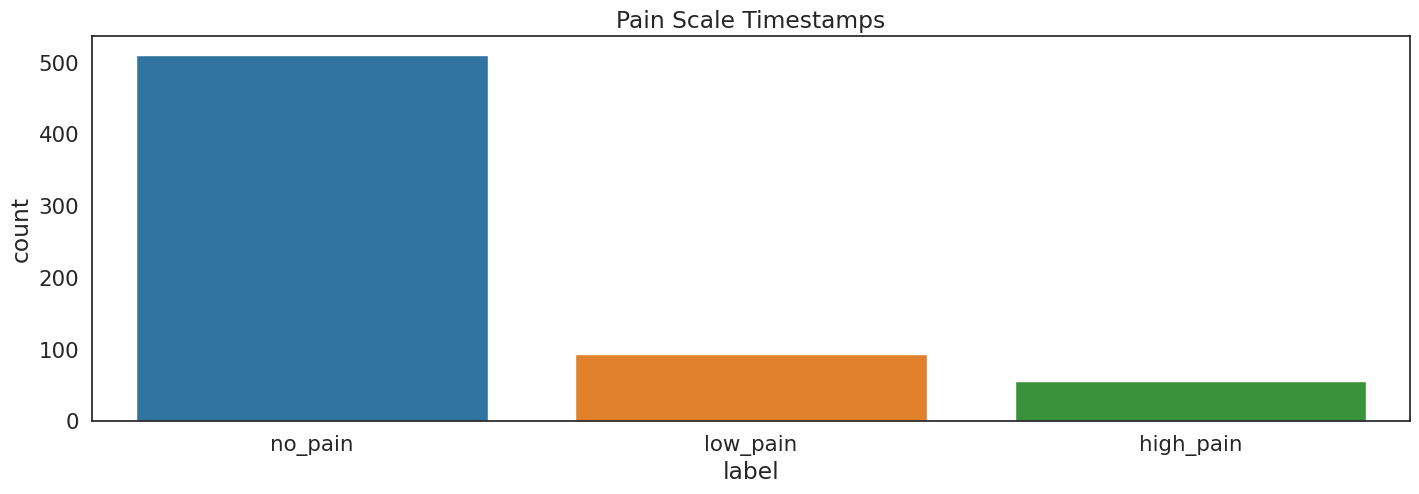

In [69]:
# Visualise the count of timestamps for each activity
plt.figure(figsize=(17, 5))
sns.countplot(
    x='label',
    data=df_labels,
    order=df_labels['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pain Scale Timestamps')

# Display the plot
plt.show()

In [70]:
# All sample_indexes have the same number of timesteps
df.groupby('sample_index').size().nunique() == 1

True

In [71]:
df = df.merge(df_labels, on='sample_index', how='left')

In [72]:
df.head(5)

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,label
0,0,0,2.0,0.0,2.0,1.0,1.094705,0.985281,1.018302,1.010385,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,no_pain
1,0,1,2.0,2.0,2.0,2.0,1.135183,1.021175,0.994343,1.052364,...,3.976952e-07,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,no_pain
2,0,2,2.0,0.0,2.0,2.0,1.080745,0.962842,1.009588,0.977169,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,no_pain
3,0,3,2.0,2.0,2.0,2.0,0.938017,1.081592,0.998021,0.987283,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,no_pain
4,0,4,2.0,2.0,2.0,2.0,1.090185,1.032145,1.008710,0.963658,...,4.437265e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,no_pain


The dataset is composed of 661 different executions


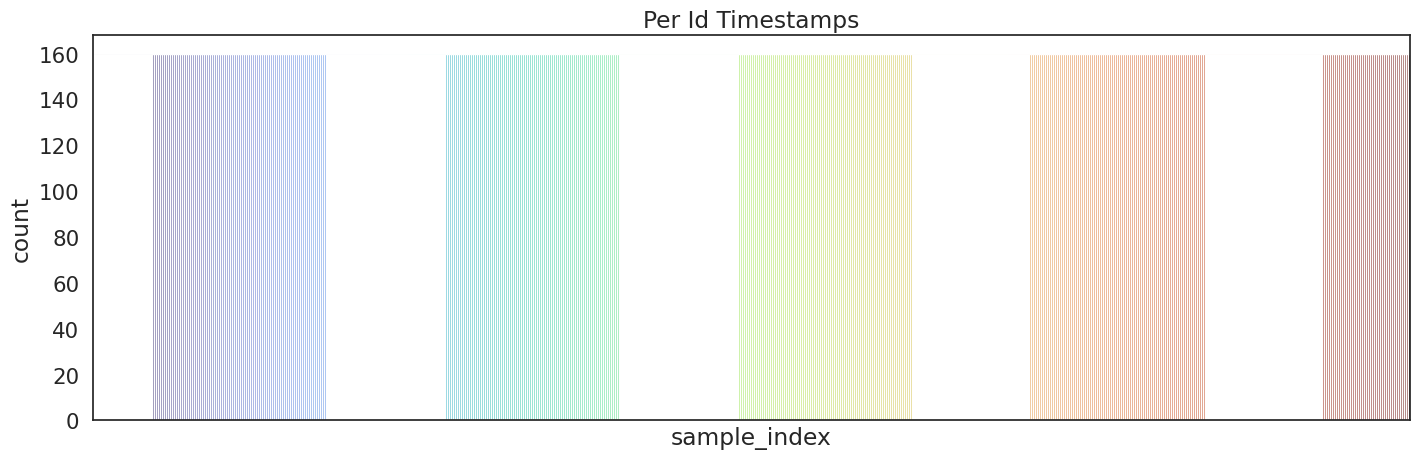

In [73]:
# Print the number of unique activity executions
print(f'The dataset is composed of {df["sample_index"].nunique()} different executions')

# Count the unique IDs for distinct activity executions
n_users = len(df['sample_index'].unique())

# Create a custom colour map for better distinction of unique IDs
colors = plt.cm.turbo(np.linspace(0, 1, n_users))

# Visualise the count of timestamps per unique ID
plt.figure(figsize=(17, 5))
sns.countplot(
    x='sample_index',
    data=df,
    order=df['sample_index'].value_counts().index,
    palette=colors
)

# Set the title of the plot and disable x-axis labels for clarity
plt.title('Per Id Timestamps')
plt.xticks([], [])  # Remove x-axis ticks and labels

# Display the plot
plt.show()

In [74]:
# Get unique user IDs and shuffle them
unique_users = df['sample_index'].unique() # 661
random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_users)

# Define the number of users for validation and test sets
N_VAL_USERS = 100

# Calculate the number of users for the training set
n_train_users = len(unique_users) - N_VAL_USERS

# Split the shuffled user IDs into training, validation, and test sets
train_users = unique_users[:n_train_users]
val_users = unique_users[n_train_users:n_train_users + N_VAL_USERS]

# Split the dataset into training, validation, and test sets based on user IDs
df_train = df[df['sample_index'].isin(train_users)]
df_val = df[df['sample_index'].isin(val_users)]

# Print the shapes of the training, validation, and test sets
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')

Training set shape: (89760, 37)
Validation set shape: (16000, 37)


In [75]:
# Define a mapping of activity names to integer labels
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}

# Map activity names to integers in the training set
df_train['label'] = df_train['label'].map(label_mapping)

# Map activity names to integers in the validation set
df_val['label'] = df_val['label'].map(label_mapping)

In [76]:
df_train.head(5)

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,label
0,0,0,2.0,0.0,2.0,1.0,1.094705,0.985281,1.018302,1.010385,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0
1,0,1,2.0,2.0,2.0,2.0,1.135183,1.021175,0.994343,1.052364,...,3.976952e-07,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0
2,0,2,2.0,0.0,2.0,2.0,1.080745,0.962842,1.009588,0.977169,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0
3,0,3,2.0,2.0,2.0,2.0,0.938017,1.081592,0.998021,0.987283,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0
4,0,4,2.0,2.0,2.0,2.0,1.090185,1.032145,1.008710,0.963658,...,4.437265e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0


In [77]:
scale_columns = df_train.columns [2:-1]

# Calculate the minimum and maximum values from the training data only
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set
    df_train[column] = (df_train[column] - mins[column]) / (maxs[column] - mins[column])

    # Normalise the validation set
    df_val[column] = (df_val[column] - mins[column]) / (maxs[column] - mins[column])

In [78]:
scale_columns

Index(['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4',
       'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05',
       'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11',
       'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17',
       'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23',
       'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29'],
      dtype='object')

In [79]:
df_train.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,label
0,0,0,1.0,0.0,1.0,0.5,0.777507,0.738252,0.779512,0.804419,...,2.426544e-06,1.374706e-06,0.000015,3.162814e-04,0.000004,0.014211,0.011376,0.018978,0.020291,0
1,0,1,1.0,1.0,1.0,1.0,0.806256,0.765147,0.761153,0.838021,...,2.757563e-07,4.026520e-07,0.000022,9.828599e-07,0.000000,0.010745,0.000000,0.009473,0.010006,0
2,0,2,1.0,0.0,1.0,1.0,0.767592,0.721439,0.772834,0.777832,...,1.063529e-07,1.440847e-08,0.000005,6.626013e-05,0.000003,0.013093,0.006830,0.017065,0.016856,0
3,0,3,1.0,1.0,1.0,1.0,0.666220,0.810416,0.763971,0.785928,...,6.981461e-06,3.065580e-07,0.000007,1.199337e-06,0.000000,0.009502,0.006274,0.020264,0.017981,0
4,0,4,1.0,1.0,1.0,1.0,0.774297,0.773366,0.772162,0.767017,...,3.076737e-06,1.723862e-08,0.000006,1.307199e-06,0.000007,0.004212,0.002132,0.023389,0.018477,0


In [80]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89760 entries, 0 to 105599
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_index   89760 non-null  int64  
 1   time           89760 non-null  int64  
 2   pain_survey_1  89760 non-null  float32
 3   pain_survey_2  89760 non-null  float32
 4   pain_survey_3  89760 non-null  float32
 5   pain_survey_4  89760 non-null  float32
 6   joint_00       89760 non-null  float32
 7   joint_01       89760 non-null  float32
 8   joint_02       89760 non-null  float32
 9   joint_03       89760 non-null  float32
 10  joint_04       89760 non-null  float32
 11  joint_05       89760 non-null  float32
 12  joint_06       89760 non-null  float32
 13  joint_07       89760 non-null  float32
 14  joint_08       89760 non-null  float32
 15  joint_09       89760 non-null  float32
 16  joint_10       89760 non-null  float32
 17  joint_11       89760 non-null  float32
 18  joint_12  

In [81]:
# 160 timestamps for sample
# Define the window size
WINDOW_SIZE = 20

# Define the stride for overlapping windows
STRIDE = 5

In [82]:
# Define a function to build sequences from the dataset
def build_sequences(df, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp = df[df['sample_index'] == id][scale_columns].values

        # Retrieve the activity label for the current ID
        label = df[df['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(scale_columns)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [83]:
print(df['sample_index'].nunique())

661


In [84]:
# Generate sequences and labels for the training set
X_train, y_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the validation set
X_val, y_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)

# Print the shapes of the generated datasets and their labels
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((18513, 20, 34), (18513,), (3300, 20, 34), (3300,))

In [85]:
X_train.shape

(18513, 20, 34)

In [86]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [87]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

In [88]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 512

In [89]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [90]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [91]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([512, 20, 34])
Labels batch shape: torch.Size([512])


# MODEL BUILDING

In [92]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [93]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 20, 128], [2, -1, 128]] 54,016         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,403
Trainable params: 54,403
Non-trainable params: 0
-------------------------------------------------------------------------------


## 🧮 **Network and Training Hyperparameters**

In [94]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

## 🧠 **Model Training**

In [95]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [96]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [97]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [98]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [99]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [100]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "rnn"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 20, 128], [2, -1, 128]] 54,016         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,403
Trainable params: 54,403
Non-trainable params: 0
-------------------------------------------------------------------------------


In [101]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="rnn",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=0.7121, F1 Score=0.6765 | Val: Loss=0.6847, F1 Score=0.6641
Epoch   2/500 | Train: Loss=0.6159, F1 Score=0.7188 | Val: Loss=0.6692, F1 Score=0.6843
Epoch   3/500 | Train: Loss=0.5827, F1 Score=0.7486 | Val: Loss=0.6054, F1 Score=0.7413
Epoch   4/500 | Train: Loss=0.5188, F1 Score=0.7873 | Val: Loss=0.5407, F1 Score=0.7566
Epoch   5/500 | Train: Loss=0.6742, F1 Score=0.6972 | Val: Loss=0.6882, F1 Score=0.6874
Epoch   6/500 | Train: Loss=0.5893, F1 Score=0.7536 | Val: Loss=0.6056, F1 Score=0.7201
Epoch   7/500 | Train: Loss=0.5750, F1 Score=0.7549 | Val: Loss=0.6798, F1 Score=0.6763
Epoch   8/500 | Train: Loss=0.5470, F1 Score=0.7752 | Val: Loss=0.5717, F1 Score=0.7650
Epoch   9/500 | Train: Loss=0.4885, F1 Score=0.8134 | Val: Loss=0.5643, F1 Score=0.7506
Epoch  10/500 | Train: Loss=0.4458, F1 Score=0.8240 | Val: Loss=0.5021, F1 Score=0.8005
Epoch  11/500 | Train: Loss=0.4024, F1 Score=0.8486 | Val: Loss=0.5278, F1 Score=0.7535
Epoch  12

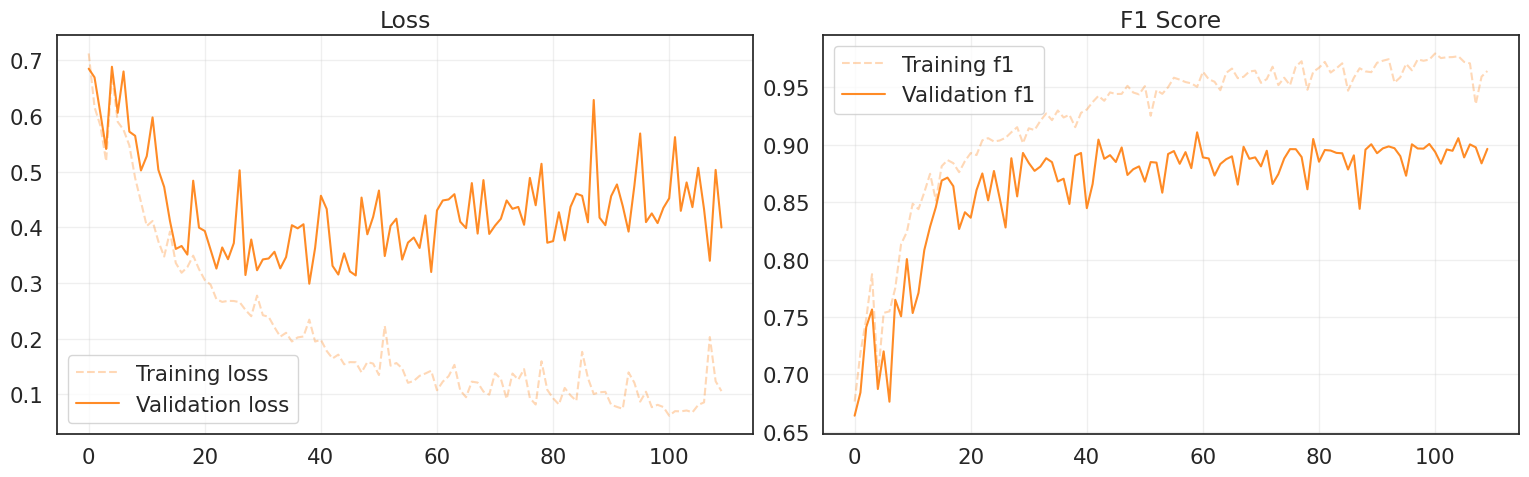

In [102]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9148
Precision over the validation set: 0.9118
Recall over the validation set: 0.9148
F1 score over the validation set: 0.9108


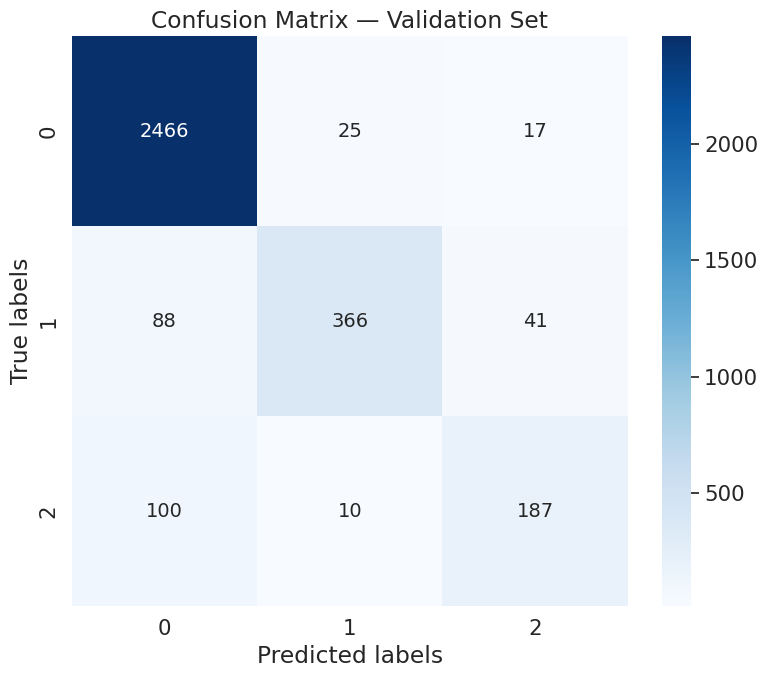

In [103]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [192]:
# Define a function to build sequences from the dataset
def build_sequences_test(df, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    sample_indices = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp = df[df['sample_index'] == id][scale_columns].values

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(scale_columns)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            idx += stride
            sample_indices.append(id)

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)

    return dataset, sample_indices

In [193]:
df_test = pd.read_csv('pirate_pain_test.csv', header=0)

print(len(df_test))

float_cols = df_test.select_dtypes(include=['float64', 'int64']).columns[2:]
for col in float_cols:
    df_test[col] = df_test[col].astype(np.float32)

df_test.drop(columns=["n_legs", "n_hands", "n_eyes"], inplace=True)
df_test.drop(columns=["joint_30"], inplace=True)

for column in scale_columns:
    # Normalise the test set
    df_test[column] = (df_test[column] - mins[column]) / (maxs[column] - mins[column])

# Generate sequences and labels for the test set
X_test, sample_indices = build_sequences_test(df_test, WINDOW_SIZE, STRIDE)
print(X_test.shape, len(sample_indices))

test_ds = TensorDataset(torch.from_numpy(X_test))

train_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

211840
(43692, 20, 34) 43692


In [194]:
logits_val = []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, in train_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        logits_val.append(logits.cpu().numpy())

# Combine all batches
logits_val = np.concatenate(logits_val, axis=0)  # shape: [num_windows, num_classes]

In [195]:
print(np.unique(sample_indices))

[   0    1    2 ... 1321 1322 1323]


In [196]:
print(logits_val[:100])

[[-2.1972651   3.4563186   0.32248637]
 [ 4.917245   -3.359022   -3.0422895 ]
 [ 6.2791023  -5.4295745  -1.383955  ]
 [ 1.8821896  -1.6285646  -1.0831401 ]
 [-2.5042481   2.8650055  -0.40154797]
 [ 0.27790475 -1.9124883   0.93931496]
 [ 1.7595769   1.051972   -4.6544223 ]
 [ 5.060829   -6.541638    1.4008596 ]
 [ 3.84128    -5.096328    0.606994  ]
 [ 2.1111245   1.4616164  -5.436171  ]
 [-0.02300057 -2.6657112   1.3123504 ]
 [-1.8974949   3.345298   -2.44247   ]
 [-0.1521163   1.1786612  -2.863494  ]
 [ 0.4736094   2.6769242  -4.5953956 ]
 [ 5.9895606  -4.7350516  -1.7718472 ]
 [ 0.8299522  -0.39898184 -1.1948853 ]
 [-2.727674    2.9109488   0.25088075]
 [-1.9553604   3.6829407  -2.6168873 ]
 [-4.5694737   5.286893   -0.8037059 ]
 [ 4.044234   -2.6004508  -3.493791  ]
 [ 3.4184718  -3.1153936  -1.6232911 ]
 [ 3.2364502  -2.0249205  -3.4062347 ]
 [ 4.9778733  -3.6011217  -1.891276  ]
 [ 5.050385   -3.1528368  -2.6646647 ]
 [ 4.4381022  -1.9143243  -4.1737733 ]
 [ 4.3962746  -5.4683723 

In [197]:
# sample_indices should be same length as logits_val
df_results = pd.DataFrame({
    "sample_index": sample_indices,
    "logits": list(logits_val)
})

# Average logits per sample
df_mean = df_results.groupby("sample_index")["logits"].apply(
    lambda arrs: np.mean(np.vstack(arrs), axis=0)
)

# Final predictions = argmax of mean logits
final_preds = np.array([logit_vec.argmax() for logit_vec in df_mean])

In [198]:
df_mean

sample_index
0        [1.820624, -1.1745639, -1.4912317]
1       [2.7807207, -1.8749648, -1.7785023]
2        [2.6450057, -1.9693975, -1.420177]
3         [2.21108, -1.5699489, -1.3707685]
4        [3.198725, -2.5467126, -1.3581775]
                       ...                 
1319    [2.6313782, -1.7535902, -1.6414812]
1320    [3.2822661, -2.2522826, -2.1389666]
1321    [2.5911689, -1.9794351, -1.4991568]
1322    [2.7306252, -1.6588157, -1.8647681]
1323     [2.4986129, -1.521633, -1.9224391]
Name: logits, Length: 1324, dtype: object

In [199]:
np.unique(final_preds)

array([0])

In [180]:
# invert it so we can map int → string
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Apply mapping to your final_preds
labels = [inv_label_mapping[p] for p in final_preds]

df_mean = pd.DataFrame({
    "sample_index": df_mean.index,
    "labels": labels
})
df_mean.head()

,sample_index,labels
0,0,no_pain
1,1,no_pain
2,2,no_pain
3,3,no_pain
4,4,no_pain


In [181]:
df_mean.to_csv("submission.csv", index=False)

In [203]:
df_last = df_results.groupby("sample_index")["logits"].apply(lambda arrs: arrs.iloc[-1])

# Final predictions = argmax of mean logits
final_preds = np.array([logit_vec.argmax() for logit_vec in df_last])

# invert it so we can map int → string
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Apply mapping to your final_preds
labels = [inv_label_mapping[p] for p in final_preds]

df_mean = pd.DataFrame({
    "sample_index": df_mean.index,
    "labels": labels
})
df_mean.head()

df_mean.to_csv("submission.csv", index=False)

In [205]:
df_mean["labels"].value_counts()

labels
no_pain      1029
low_pain      190
high_pain     105
Name: count, dtype: int64